# Clustering Model Comparison on LEGO image

# Load necessary libraries

In [1]:
!pip install opencv-python

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Setup and imports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN



from PIL import Image
import requests

import cv2 as cv


# Sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

# Load lego image

In [3]:
from PIL import Image
im = Image.open('lego.jpg')

In [4]:
img_dat=np.asarray(im)
img_dat.shape

(2178, 3278, 3)

(-0.5, 3277.5, 2177.5, -0.5)

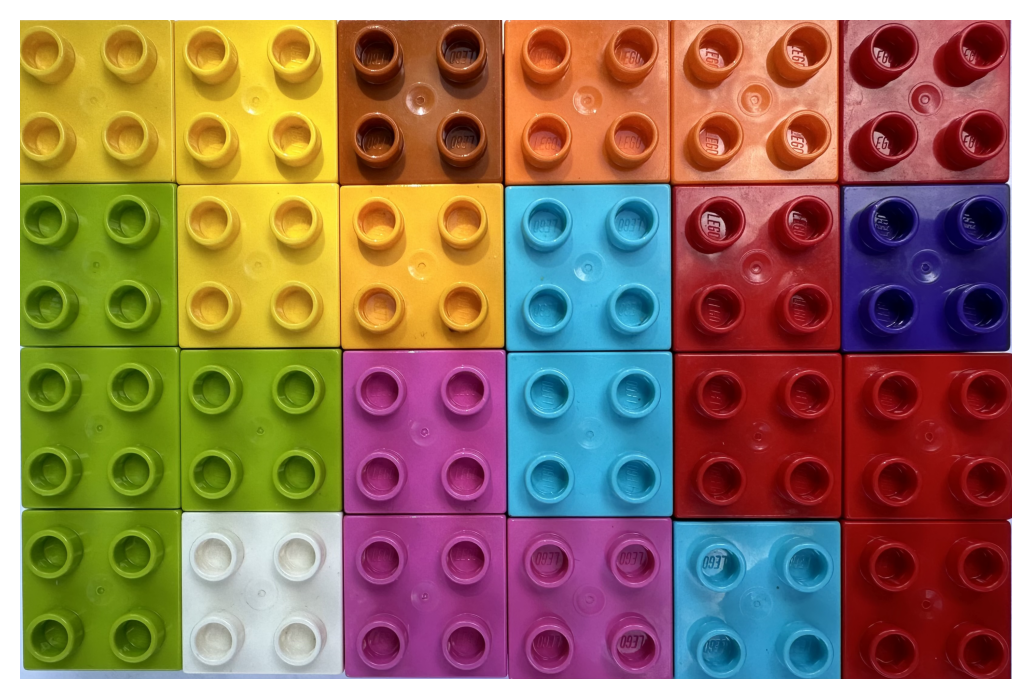

In [65]:
plt.imshow(img_dat)
plt.axis('off')

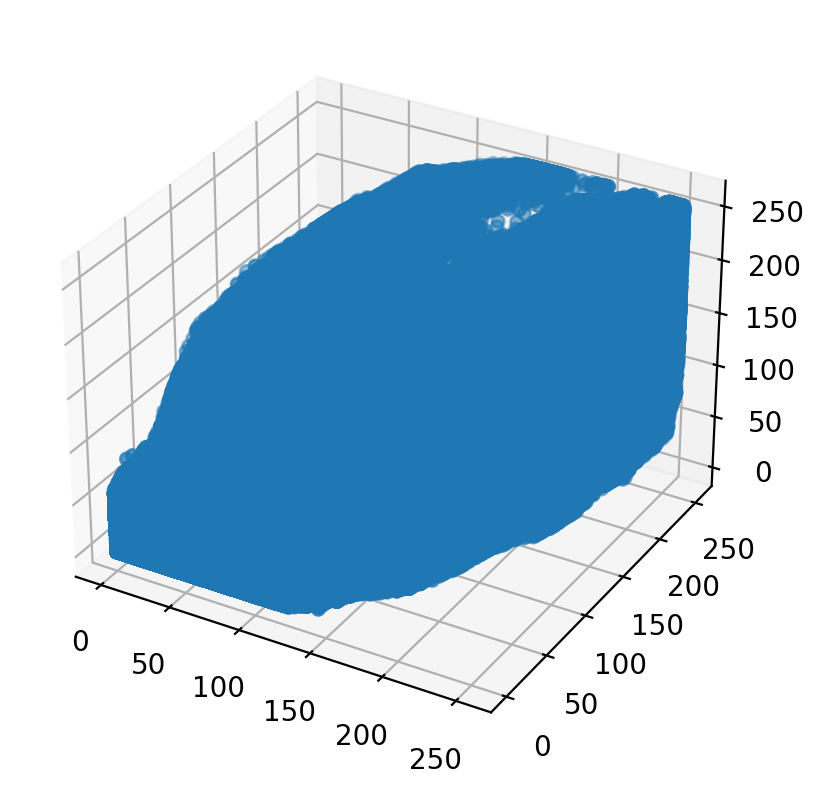

In [68]:
ax = plt.axes(projection ="3d")
ax.scatter3D(img_dat[:,:,0],img_dat[:,:,1],img_dat[:,:,2])
#ax.set_title('Pixel Values ')
plt.show()


In [6]:
img_flat = img_dat.reshape(img_dat.shape[0]*img_dat.shape[1],3)
img_flat[:5,:]

array([[225, 233, 222],
       [225, 233, 222],
       [225, 233, 222],
       [224, 232, 221],
       [224, 232, 221]], dtype=uint8)

In [66]:
img_flat.shape

(7139484, 3)

# Clustering Methods

## K-Means 

In [8]:
#kmeans3 = KMeans(n_clusters=3, random_state=0).fit(img_flat)
kmeans6 = KMeans(n_clusters=6, random_state=0).fit(img_flat)
#kmeans10 = KMeans(n_clusters=10, random_state=0).fit(img_flat)

In [9]:
#kmeans3.cluster_centers_
kmeans6.cluster_centers_
#kmeans10.cluster_centers_

array([[160.82841996,  71.11404765, 125.39449203],
       [226.33168407, 169.88072435,  59.36485083],
       [ 53.67863842, 151.88143234, 191.94843796],
       [122.04750063, 124.01623448,  19.36658181],
       [ 99.89181587,  18.29956803,  25.69122352],
       [204.33023523, 195.27340843, 193.36551997]])

In [10]:
kmeans6.labels_

array([5, 5, 5, ..., 0, 5, 5], dtype=int32)

In [11]:
len(kmeans6.labels_)

7139484

In [12]:
np.unique(kmeans6.labels_)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [13]:
img_flat_km6 = img_flat.copy()
for i in np.unique(kmeans6.labels_):
    img_flat_km6[kmeans6.labels_==i,:]=kmeans6.cluster_centers_[i]
    

In [14]:
img_flat_km6

array([[204, 195, 193],
       [204, 195, 193],
       [204, 195, 193],
       ...,
       [160,  71, 125],
       [204, 195, 193],
       [204, 195, 193]], dtype=uint8)

In [15]:
img_dat_km6=img_flat_km6.reshape(img_dat.shape)
img_dat_km6.shape


(2178, 3278, 3)

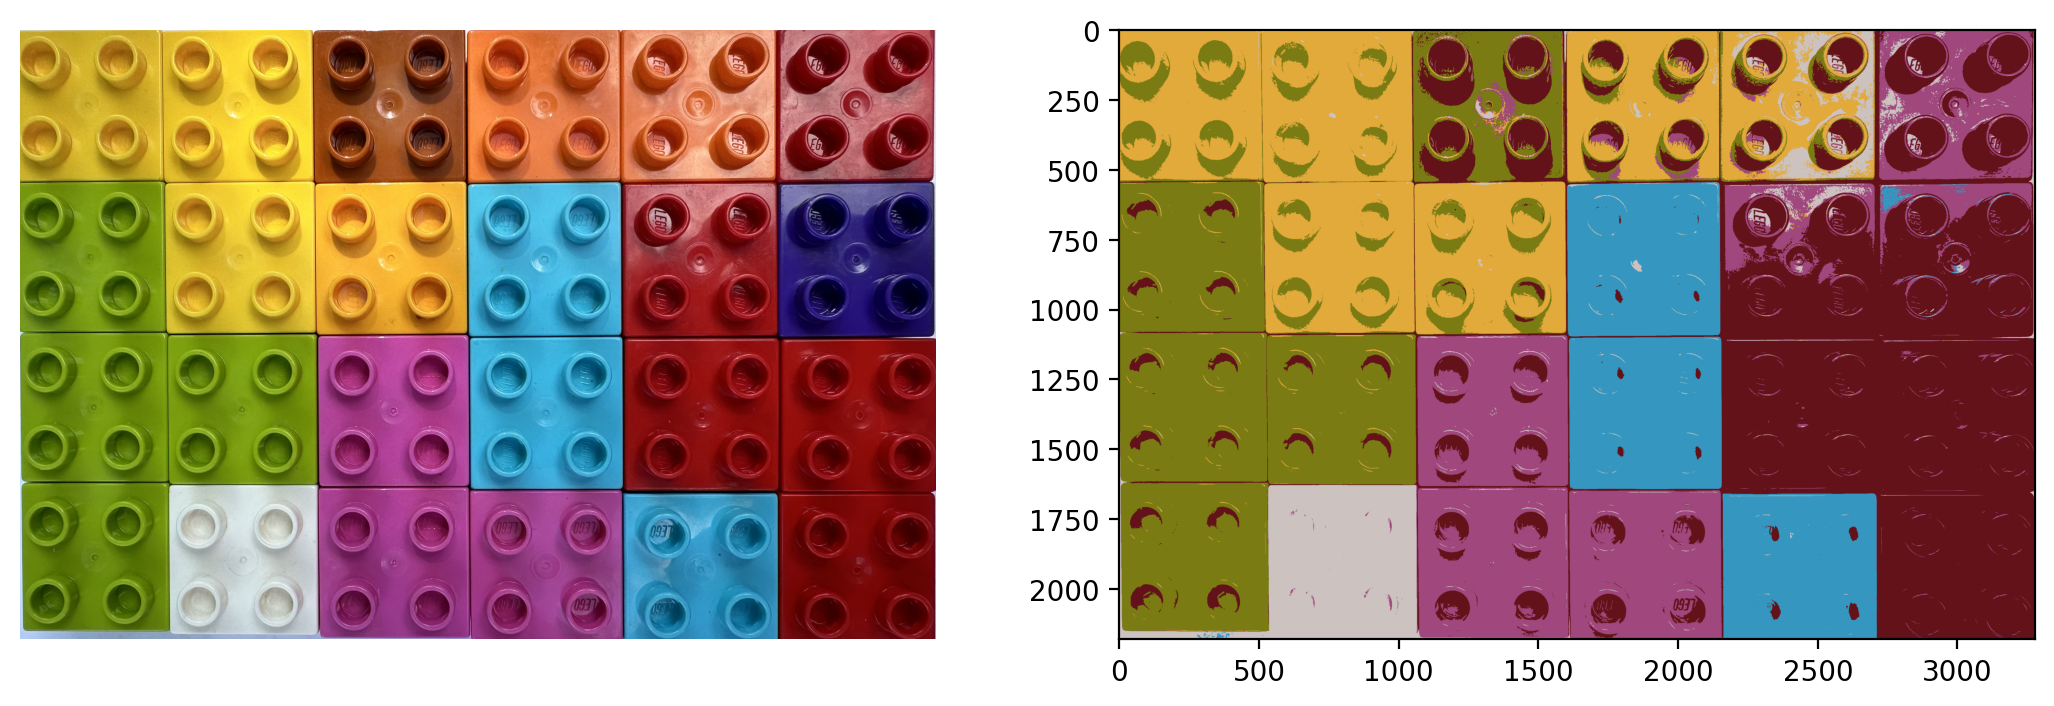

In [16]:
fig, ax = plt.subplot_mosaic([['original', 
                               #'n=3 kmeans', 
                               #'n=10 kmeans', 
                               'n=6 kmeans']],
                             figsize=(13,9.5))

ax['original'].imshow(img_dat)
ax['original'].axis('off')

ax['n=6 kmeans'].imshow(img_dat_km6)

In [17]:
img_km= []
inertia_km= []
k_vals = list(range(2,21,2))

for k in k_vals:
    
    img_flat = img_dat.reshape(img_dat.shape[0]*img_dat.shape[1],3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_flat)
    img_flat2 = img_flat.copy()

    for i in np.unique(kmeans.labels_):
        img_flat2[kmeans.labels_==i,:] = kmeans.cluster_centers_[i]

    img2 = img_flat2.reshape(img_dat.shape)

    img_km.append(img2)
    inertia_km.append(kmeans.inertia_)

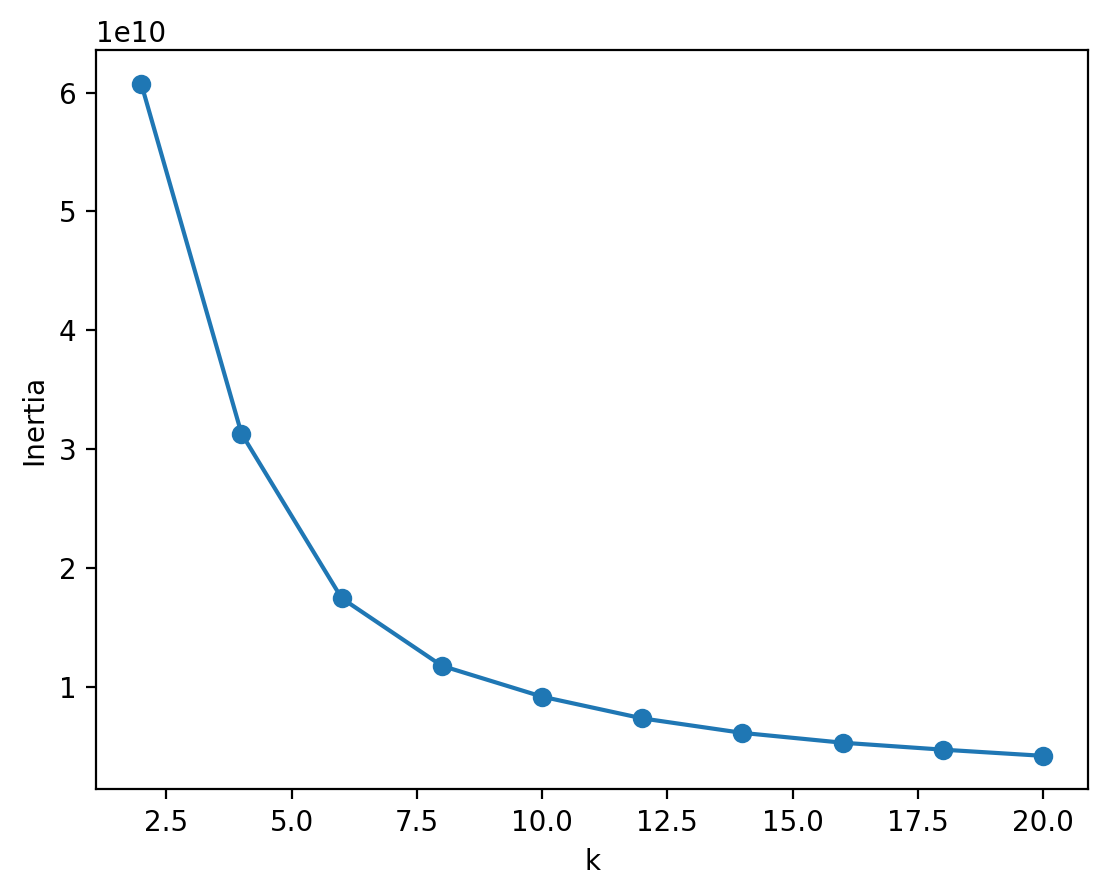

In [18]:
plt.plot(k_vals,inertia_km)
plt.scatter(k_vals,inertia_km)

plt.xlabel('k')
plt.ylabel('Inertia');


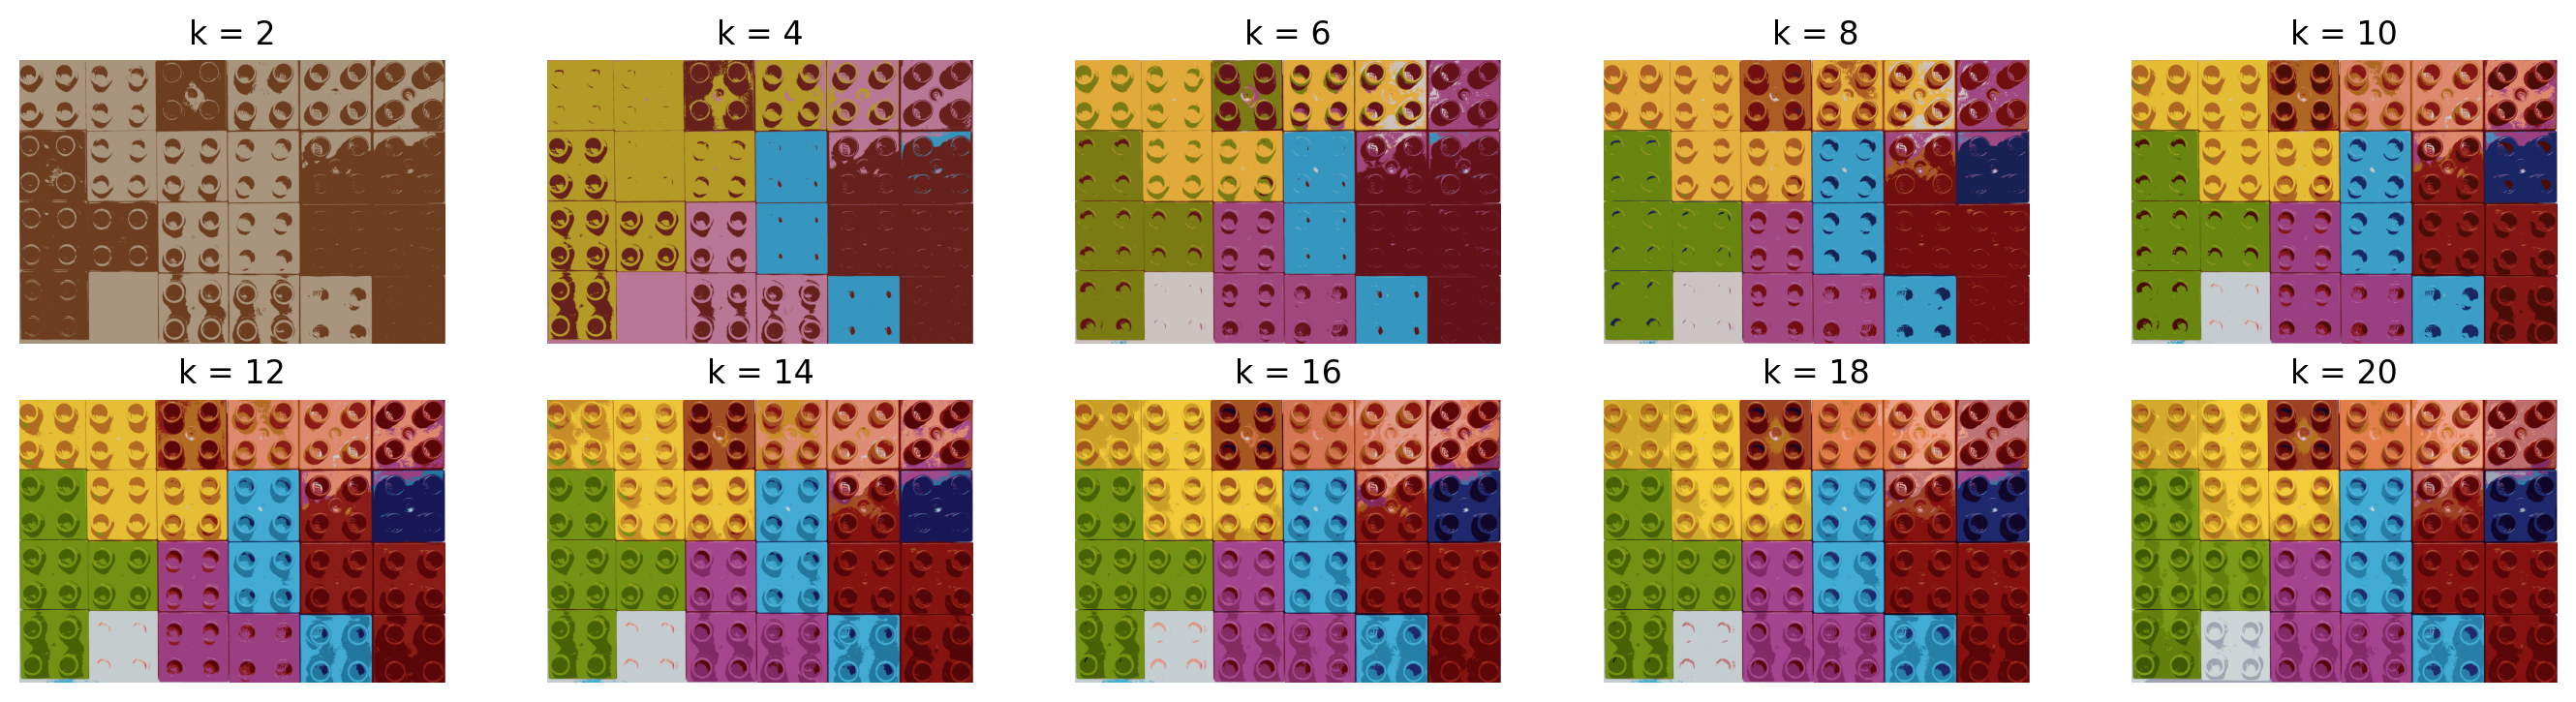

In [29]:
plt.figure(figsize=[17,11])
for i in range(len(k_vals)):
    plt.subplot(5,5,i+1)
    plt.imshow(img_km[i])
    plt.title('k = '+ str(k_vals[i]))
    plt.axis('off');


## Gaussian Mixture

In [34]:
n = 2
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(img_flat)
labels = gmm.predict(img_flat) # num of pixels x 1


seg = np.zeros(img_flat.shape) # num of pixels x 3
for label in range(n):
    seg[labels == label] = gmm.means_[label]

seg = seg.reshape(img_dat.shape).astype(np.uint8)


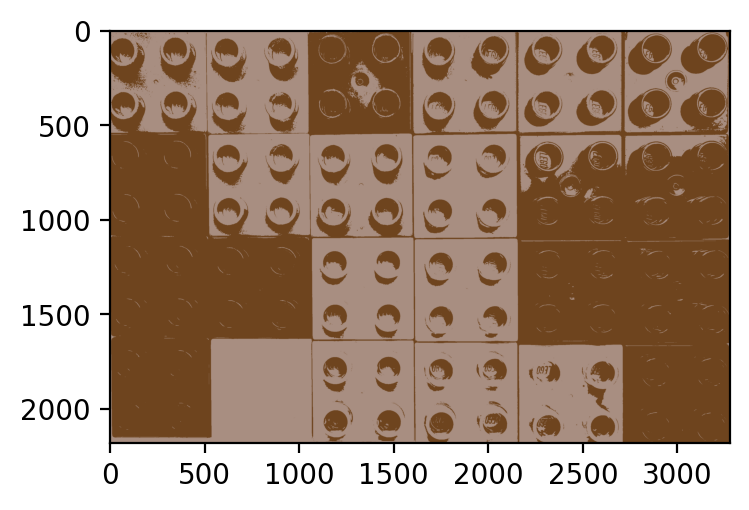

In [144]:
plt.figure(figsize=(4,4))
plt.imshow(seg)
plt.show()

In [139]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [138]:
gmm.means_

array([[ 26.93042441, 109.03974176, 144.37425717],
       [153.56376433,  57.54904172, 128.70622052],
       [219.17971699, 177.54275146,  46.83406534],
       [117.48815246,  16.80294169,  16.16215332],
       [190.31791729, 198.97722397, 203.60059225],
       [101.97827698, 131.96931929,  15.75592362],
       [ 60.81579107, 165.0707284 , 206.19332277],
       [186.49567364,  97.6244172 ,  44.56966111],
       [211.13655144, 132.6359046 , 120.13106622],
       [ 34.11135883,  24.37840873,  87.64222699]])

In [33]:
n_com = list(range(2,21,2))
img_gmm=[]

for n in n_com:
    
    img_flat = img_dat.reshape(-1,3)

    #gmm = GaussianMixture(n_components=n, covariance_type='tied')
    #gmm.fit(img_flat)
    labels= gmm.predict(img_flat)

    seg=np.zeros(img_flat.shape)
    for l in range(n):
        seg[labels==l] = gmm.means_[l]

    seg = seg.reshape(img_dat.shape).astype(np.uint8)
    img_gmm.append(seg)
    

In [35]:
#img_gmm_copy=img_gmm.copy()

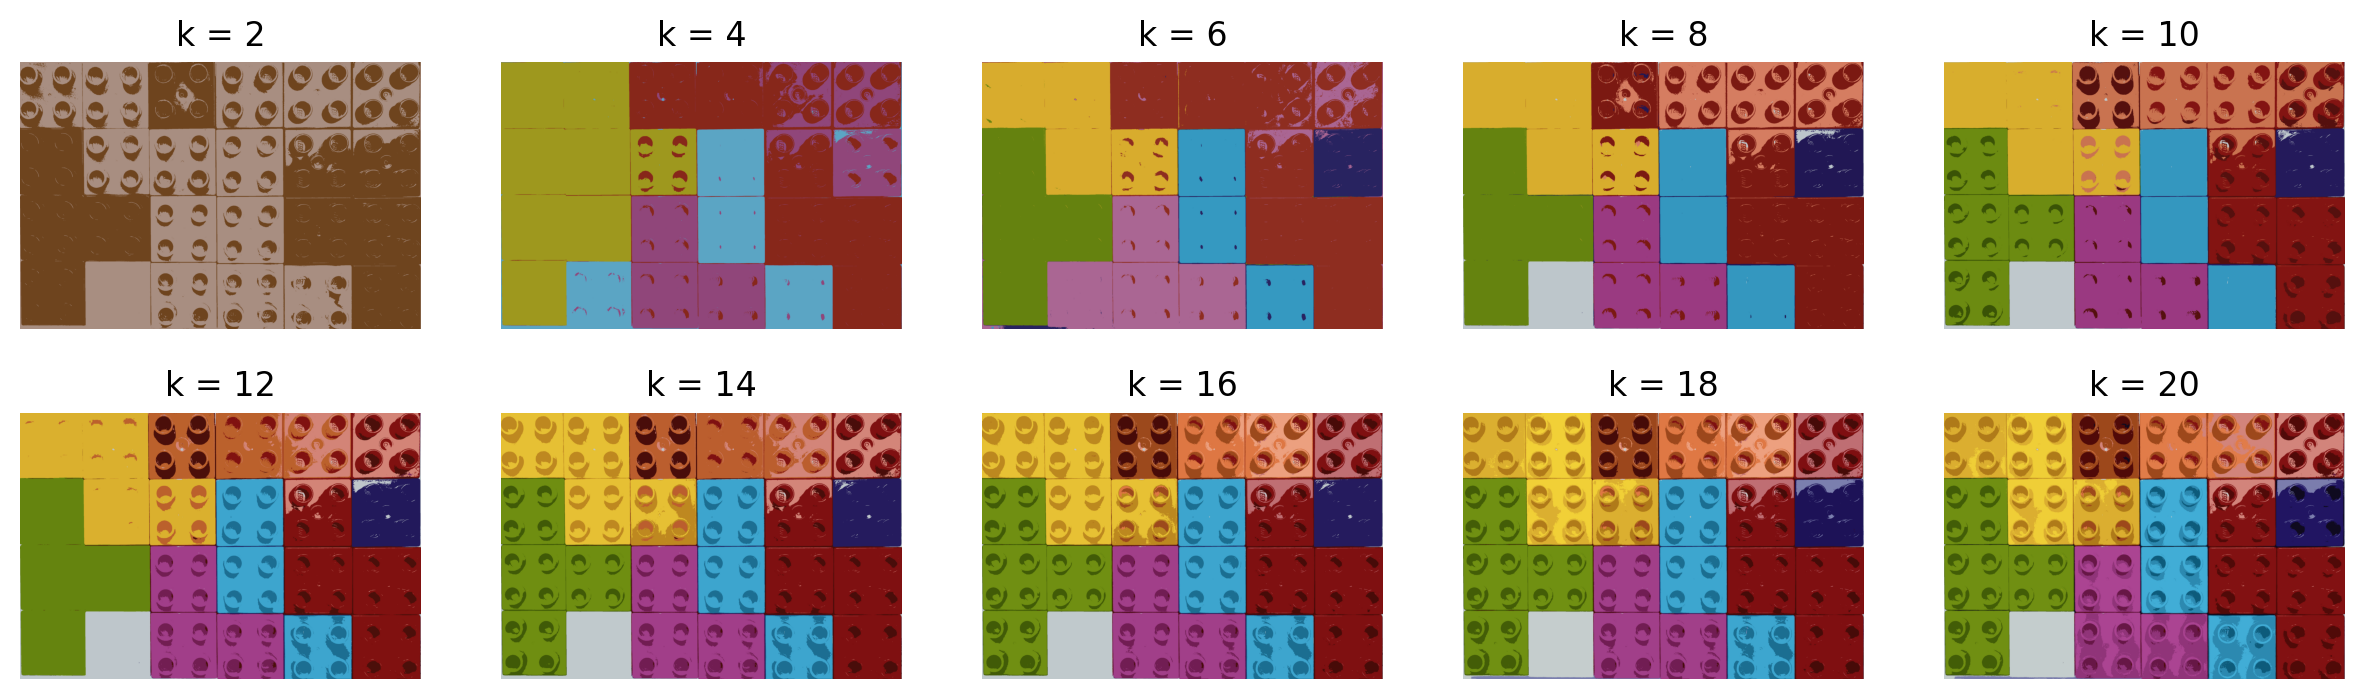

In [36]:
plt.figure(figsize=[15,11])
for i in range(len(n_com)):
    plt.subplot(5,5,i+1)
    plt.imshow(img_gmm[i])
    plt.title('k = '+ str(n_com[i]))
    plt.axis('off');


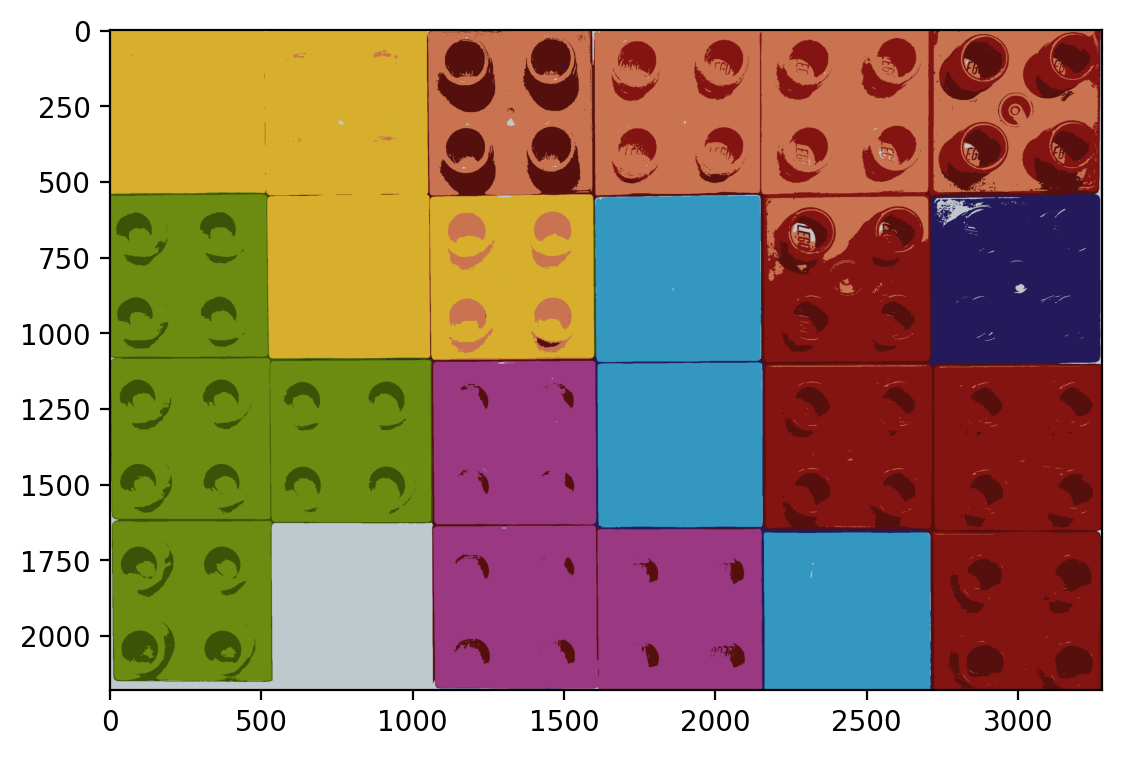

In [69]:
plt.imshow(img_gmm[4])

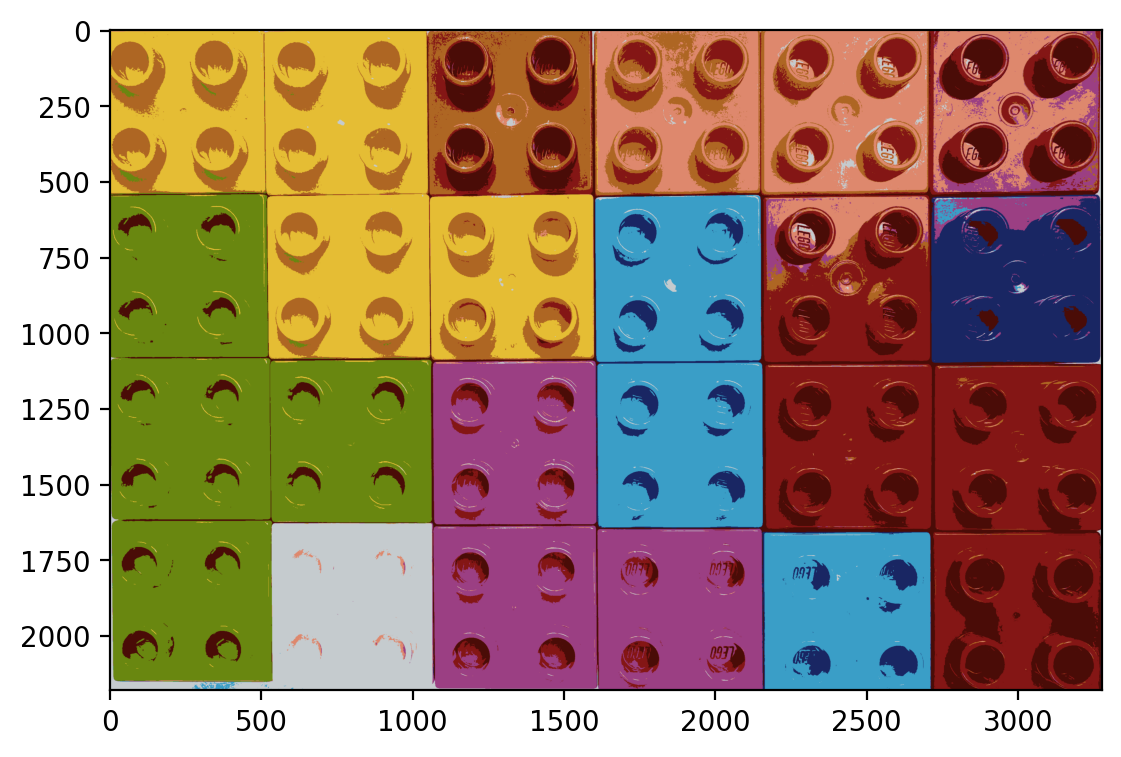

In [70]:
plt.imshow(img_km[4])

## Mean Shift

In [39]:
img_flat.dtype

dtype('uint8')

In [40]:
X = np.float32(img_flat)
X.dtype

dtype('float32')

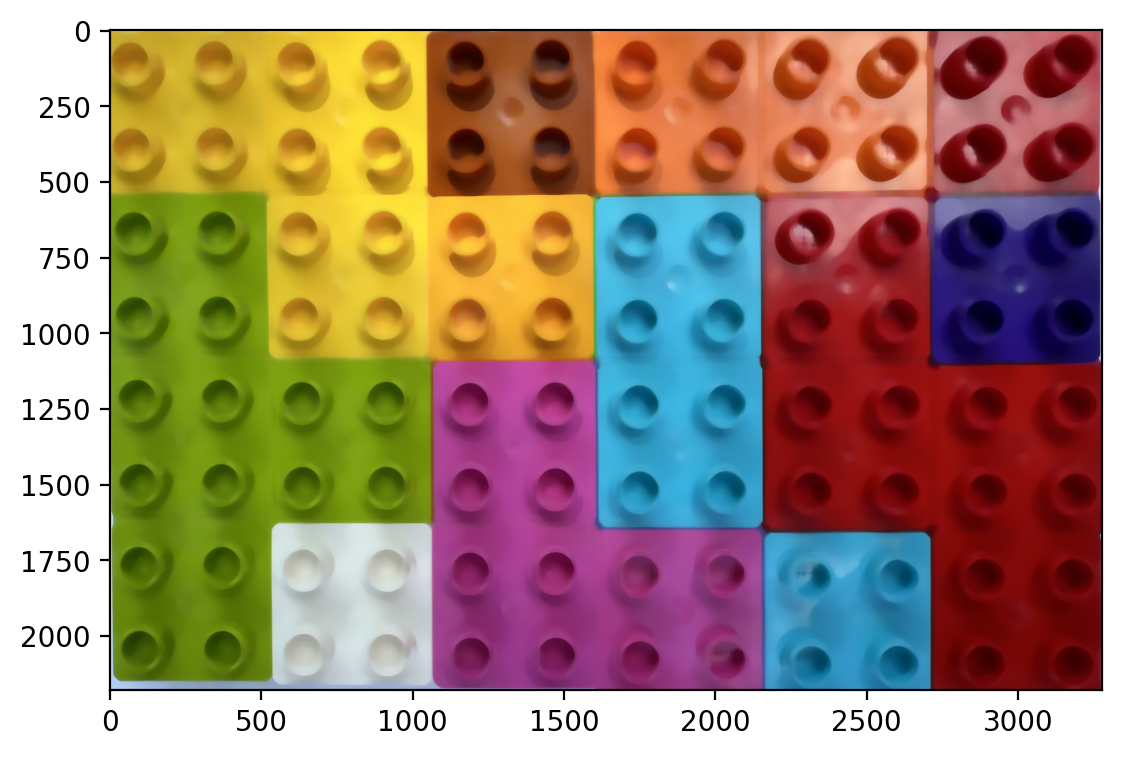

In [41]:
im_dat_ms = cv.medianBlur(img_dat, 41)
plt.imshow(im_dat_ms)

In [42]:
im_dat_ms.shape

(2178, 3278, 3)

In [43]:
img_flat_ms = im_dat_ms.reshape(-1,3)
img_flat_ms[:5,:]

array([[220, 230, 219],
       [220, 230, 219],
       [220, 230, 219],
       [220, 230, 219],
       [220, 230, 219]], dtype=uint8)

In [44]:
X = np.float32(img_flat_ms)

In [45]:
#apply mean shift

bandwidth = estimate_bandwidth(X, quantile=.06, n_samples=3000)
bandwidth 

39.51847547119042

In [46]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

MeanShift(bandwidth=39.51847547119042, bin_seeding=True)

In [49]:
labeled = ms.labels_
set(labeled)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [50]:
clusters=ms.predict(X)
set(clusters)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [51]:
ms.cluster_centers_

array([[122.40369 ,  12.118708,  12.564346],
       [109.56798 , 140.65903 ,  15.886644],
       [231.84392 , 188.79846 ,  50.39515 ],
       [158.30344 ,  60.153587, 134.51175 ],
       [ 57.080647, 160.72864 , 202.57018 ],
       [159.1734  ,  78.658325,  28.340298],
       [215.33006 , 126.46862 , 102.718155],
       [200.56535 , 210.44923 , 210.84258 ],
       [ 35.754585,  22.30947 , 103.204994],
       [ 95.28384 ,  93.90217 , 153.47403 ]], dtype=float32)

In [52]:
cluster_int8=np.uint8(ms.cluster_centers_)
cluster_int8

array([[122,  12,  12],
       [109, 140,  15],
       [231, 188,  50],
       [158,  60, 134],
       [ 57, 160, 202],
       [159,  78,  28],
       [215, 126, 102],
       [200, 210, 210],
       [ 35,  22, 103],
       [ 95,  93, 153]], dtype=uint8)

In [53]:
result=np.zeros(X.shape,dtype=np.uint8)

for label in np.unique(labeled):
    result[labeled==label, :] = cluster_int8[label,:]
    
result=result.reshape(im_dat_ms.shape)

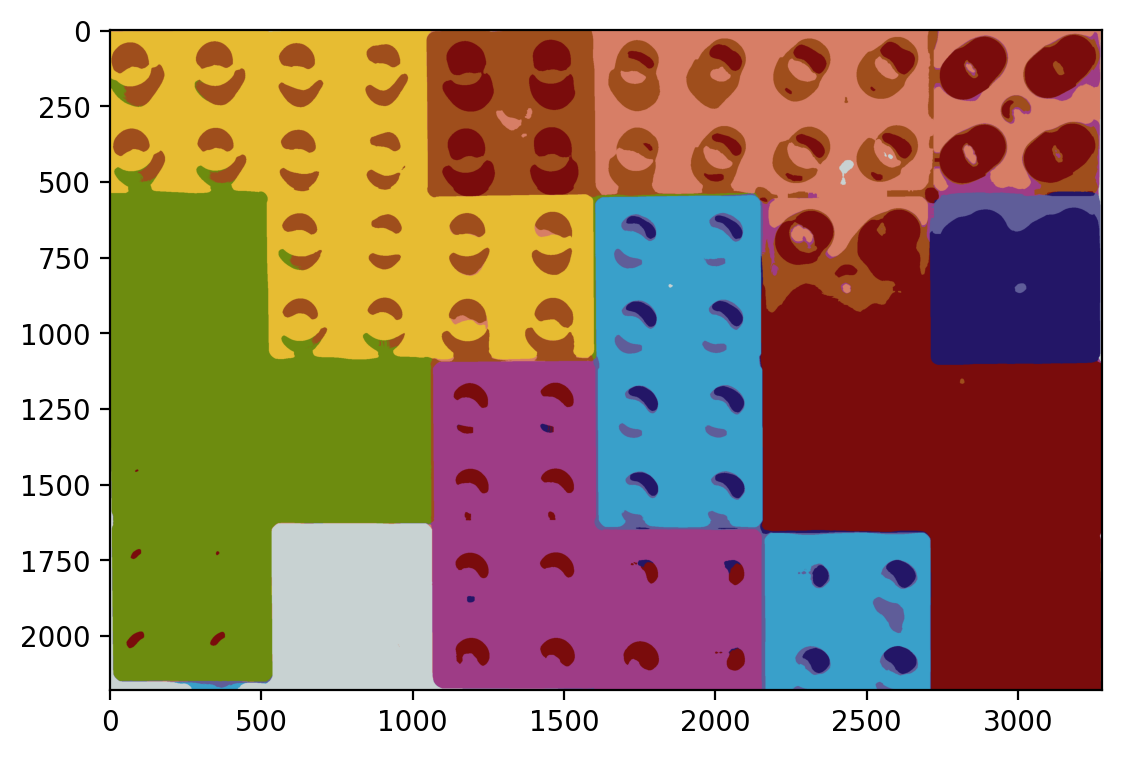

In [54]:
plt.imshow(result)

## DBScan

In [8]:
db = DBSCAN(eps=3, min_samples=10)
db

DBSCAN(eps=3, min_samples=10)

In [ ]:
dbfit = db.fit(img_flat)

# Compare Clustering Methods

(-0.5, 3277.5, 2177.5, -0.5)

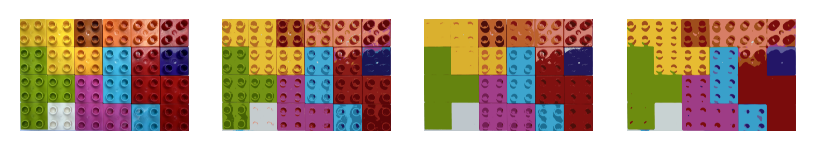

In [59]:
fig, ax = plt.subplot_mosaic([['original', 
                               'KMeans (n=10)', 
                               'Gaussian Mixture (n=10)', 
                               'Mean Shift']],
                             figsize=(13,11))

ax['original'].imshow(img_dat)
ax['original'].axis('off')

ax['KMeans (n=10)'].imshow(img_km[5])
ax['KMeans (n=10)'].axis('off')

ax['Gaussian Mixture (n=10)'].imshow(img_gmm[5])
ax['Gaussian Mixture (n=10)'].axis('off')

ax['Mean Shift'].imshow(result)
ax['Mean Shift'].axis('off')


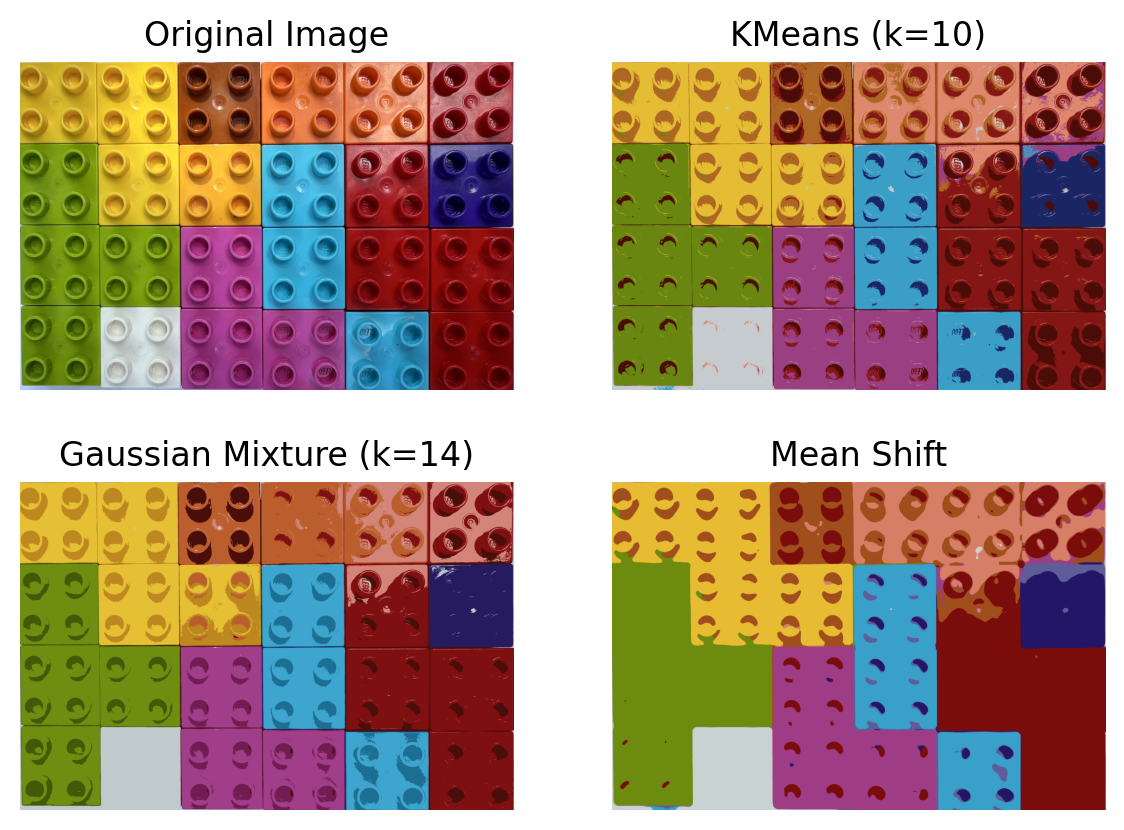

In [71]:
plt.figure(figsize=[7,5])

plt.subplot(2,2,1)
plt.imshow(img_dat)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(img_km[4])
plt.title('KMeans (k=10)')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(img_gmm[6])
plt.title('Gaussian Mixture (k=14)')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(result)
plt.title('Mean Shift')
plt.axis('off');
